# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt 

from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# A. Exploratory Data Analysis

# 1. Portfolio dataset

In [2]:
# Geting first 5 rows 
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# Getting the number of rows and columns of the dataset
portfolio.shape

(10, 6)

In [4]:
# Getting the details of columns and its datatypes 
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
# Check for duplicates
portfolio.columns.duplicated().sum()

0

In [6]:
# Missing value check
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
# Checking offer types
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

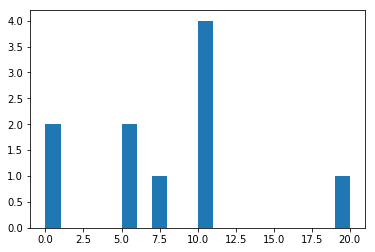

In [8]:
# Getting distribution of difficulty
plt.hist(portfolio['difficulty'], bins=20);

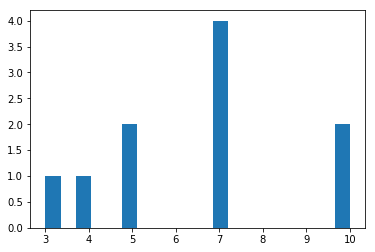

In [9]:
# Getting distribution of duration
plt.hist(portfolio['duration'], bins=20);

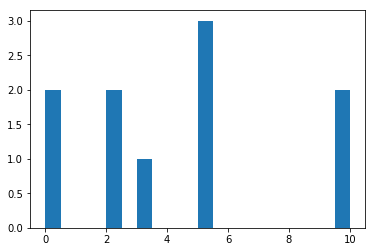

In [10]:
# Getting distribution of reward
plt.hist(portfolio['reward'], bins=20);

## Portfolio data observation :

* Dataset has 6 columns and 10 rows.
* There are no null values nor duplicates.
* Offer are of 3 types : 
	1. 'bogo'(Buy One Get One free) - 4 unique offer id
	2. 'discount' - 4 unique offer id
	3. 'informational' - 2 unique offer id
* Diffuclty ranges between 0 - 20
* Duration ranges between 3 - 10
* Reward ranges between 0 -10

# 2. Profile dataset

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
# Getting the number of rows and columns of the dataset
profile.shape

(17000, 5)

In [13]:
# Getting the details of columns and its datatypes 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
# Check for duplicates
profile.columns.duplicated().sum()

0

In [15]:
# Missing value check 
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
# Checking for duplicate at customer id level
profile['id'].nunique()

17000

Since shape of dataset and unique IDs have same count, there are no duplicate at customer id level

In [17]:
# Getting gender unique values
print(profile['gender'].value_counts())
print(profile['gender'].value_counts(normalize = True))

M    8484
F    6129
O     212
Name: gender, dtype: int64
M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64


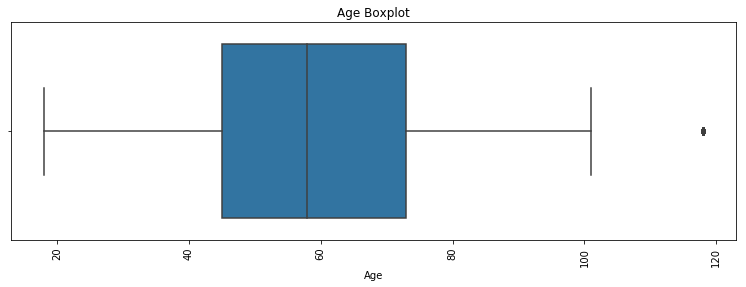

In [18]:
# Age boxplot
plt.figure(figsize=(13, 4))
sns.boxplot(profile['age'])
plt.title('Age Boxplot')
plt.xlabel('Age')
plt.xticks(rotation = 90)
plt.show();

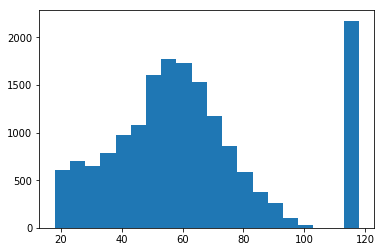

In [19]:
# Distrubition of Age
plt.hist(profile['age'], bins=20);

In [20]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [21]:
# Checking for outliers in age
profile[profile['age']>110].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [22]:
profile[profile['age']>110].head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


The 2175 records that have null gender and income seems to be imputed with age = 118. This can be corrected in feature engineering/data preprocessing

In [23]:
# Understanding income column
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

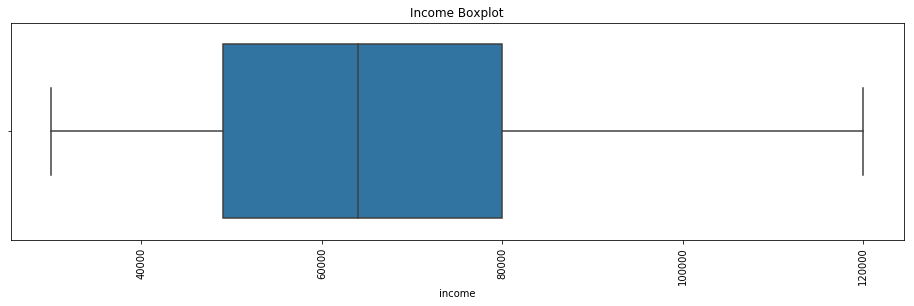

In [24]:
# Income boxplot
plt.figure(figsize=(16, 4))
sns.boxplot(profile['income'])
plt.title('Income Boxplot')
plt.xlabel('income')
plt.xticks(rotation = 90)
plt.show();

boxplot shows that the median is around 64k and most of incomes falls between 58k and 80k

# Profile data observation :

* Dataset has 5 columns and 17000 rows.
* There are 2175 null values is 'gender' and 'income' features; 
* There are 17000 unique cutomer IDs. There are no duplicates at record level
* There are 3 categories of gender - M (57%), F (41%), O (1%)
* Age ranges from 18 to 118. The 2175 records with null gender and income have age as 118. 
* Income ranges from 30k to 120k with median around 64k. Most of the customers fall between 58k to 80k range


# 3. Transcript Dataset

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
# getting the number of rows and columns of the dataset
transcript.shape

(306534, 4)

In [27]:
# checking for missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [28]:
# checking for duplicates
transcript.columns.duplicated().sum()

0

In [29]:
# checking the count of each event type
print(transcript.event.value_counts())
print(transcript.event.value_counts(normalize=True))


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64
transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64


In [30]:
# creating a dataframe to include ONLY the 'transaction' event
df_transaction = transcript[transcript['event'] == 'transaction']
#getting a random sample of 'value' column
df_transaction['value'].sample(10)

149255                 {'amount': 27.74}
170382                  {'amount': 0.36}
82500                  {'amount': 30.45}
183353                 {'amount': 17.33}
37173                  {'amount': 15.07}
46766                  {'amount': 25.01}
229322                 {'amount': 23.54}
145769                 {'amount': 44.82}
88996                   {'amount': 3.86}
194488    {'amount': 1.4100000000000001}
Name: value, dtype: object

In [31]:
# creating a dataframe to include ONLY the 'offer_received' event
df_offer_received = transcript[transcript['event'] == 'offer received']
#getting a random sample of 'value' column
df_offer_received['value'].sample(10)

63158     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
122529    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12235     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
63037     {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
155532    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
204805    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
53725     {'offer id': '3f207df678b143eea3cee63160fa8bed'}
115650    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
156377    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
247745    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [32]:
# creating a dataframe to include ONLY the 'offer viewed' event
df_offer_viewed = transcript[transcript['event'] == 'offer viewed']
#getting a random sample of 'value' column
df_offer_viewed['value'].sample(10)

184792    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
67243     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
15092     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
106232    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
80179     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
218652    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
15864     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
215671    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
140971    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
123780    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [33]:
# creating a dataframe to include ONLY the 'offer completed' event
df_offer_completed = transcript[transcript['event'] == 'offer completed']
#getting a random sample of 'value' column
df_offer_completed['value'].sample(10)

273741    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
142124    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
181063    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
22875     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
289706    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
241607    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
199443    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
26119     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
290864    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
32908     {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
Name: value, dtype: object

# Transcript data observation :

* Dataset has 4 columns and 306534 rows.
* There are no null values nor any duplicate 
* There are 4 types of events - 
	* 1. transaction 45%
    * 2. offer received 25%
    * 3. offer viewed 19%
    * 4. offer completed 11%
* Value columns contains 'key'-'value' pair (dictionary) 
	* For events = transaction, it is dollar amount of transaction
    * For other 3 events, it is a combination of offer_id and the id


# B. Data Processing

## 1. Portfolio Dataset
Processing to be applied

* Rename 'id' column to 'offer_id'.
* Label encode offer_id
* Label encode offer_type
* Onehot encode channel
* Normalize 'difficulty' and 'reward' features using the MinMaxScaler

In [34]:
# creating a copy
df_portfolio = portfolio.copy()

In [35]:
df_portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [36]:
# renaming 'id' column to offer_id.
df_portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [37]:
# Label encode offer_id
offer_id_label = df_portfolio['offer_id'].astype('category').cat.categories.tolist()
map_offer_id = {'offer_id' : {k: v for k,v in zip(offer_id_label,list(range(1,len(offer_id_label)+1)))}}
print(map_offer_id)
df_portfolio.replace(map_offer_id, inplace=True)

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}


In [38]:
# Label encode offer_type
offer_type_label = df_portfolio['offer_type'].astype('category').cat.categories.tolist()
map_offer_type = {'offer_type' : {k: v for k,v in zip(offer_type_label,list(range(1,len(offer_type_label)+1)))}}
print(map_offer_type)
df_portfolio.replace(map_offer_type, inplace=True)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


In [39]:
# Onehot encode channel
df_portfolio['channels'].head()
df_portfolio['channel_email'] = df_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
df_portfolio['channel_mobile'] = df_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
df_portfolio['channel_social'] = df_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
df_portfolio['channel_web'] = df_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
df_portfolio.drop('channels', axis=1, inplace=True)

In [40]:
# Using MinMaxScaler to Normalize 'difficulty' and 'reward' metrics

scaler = MinMaxScaler()
features = ['difficulty','reward']
df_portfolio[features] = scaler.fit_transform(df_portfolio[features])


In [41]:
df_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,7,8,1,1.0,1,1,1,0
1,0.50,5,5,1,1.0,1,1,1,1
2,0.00,4,4,3,0.0,1,1,0,1
3,0.25,7,7,1,0.5,1,1,0,1
4,1.00,10,1,2,0.5,1,0,0,1


## 2. Profile Dataset
Processing to be applied

* Rename 'id' column name to 'cust_id'
* Label encode cust_id
* Drop records with null gender and income
* Create age_buckets and label encode	
    1. college (18 - 22)
    2. adult (22 - 40)
    3. mature (41 - 60)
    4. elderly (61 and above)
* Create income_buckets and label encode
	1. low (30,000 - 50,000)
	2. med (50,0001 - 70,000)
	3. high (70,001 - 90,000)
    4. veryhigh (90,001 and above)
* label encode gender column
	1. F
    2. m
    3. O
* Create loyalty buckets based on 'became_member_on' and create 'year_of_membership' feature since 2018
	1. trialist - less than 1 years (0 - 350 days)
    2. dabbler - between 1- 2 years (351 - 700 days)
    3. loyal - more than 2 years (701 and above)

In [42]:
# creating a copy
df_profile = profile.copy()

In [43]:
df_profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
# Rename 'id' column name to 'cust_id'
df_profile.rename(columns={'id':'cust_id'},inplace=True)
df_profile = df_profile.reindex(columns=['cust_id', 'age', 'became_member_on', 'gender', 'income'])

In [45]:
# Drop records with null gender and income
df_profile.dropna(inplace=True)

In [46]:
# Creating age_buckets and label encoding
df_profile['age'] = df_profile['age'].astype(int)
df_profile['age_bucket'] = pd.cut(df_profile['age'],bins=[17, 22, 40, 60, 103],
                                 labels=['college', 'adult', 'mature', 'elderly'])
print(df_profile['age_bucket'].value_counts())                                
age_bucket_label = df_profile['age_bucket'].astype('category').cat.categories.tolist()
map_age_bucket = {'age_bucket' : {k: v for k,v in zip(age_bucket_label,list(range(1,len(age_bucket_label)+1)))}}
df_profile.replace(map_age_bucket, inplace=True)

mature     5981
elderly    5542
adult      2691
college     611
Name: age_bucket, dtype: int64


In [47]:
# Create income_buckets and label encode
df_profile['income'] = df_profile['income'].astype(int)
df_profile['income_bucket'] = pd.cut(df_profile['income'], bins=[29999, 49999, 69999, 89999, 120001],labels=['low', 'med', 'high', 'veryhigh'])
print(df_profile['income_bucket'].value_counts())                                
income_bucket_label = df_profile['income_bucket'].astype('category').cat.categories.tolist()
map_income_bucket = {'income_bucket' : {k: v for k,v in zip(income_bucket_label,list(range(1,len(income_bucket_label)+1)))}}
df_profile.replace(map_income_bucket, inplace=True)

med         4989
low         3781
high        3747
veryhigh    2308
Name: income_bucket, dtype: int64


In [48]:
# label encode gender column
gender_label = df_profile['gender'].astype('category').cat.categories.tolist()
map_gender = {'gender' : {k: v for k,v in zip(gender_label,list(range(1,len(gender_label)+1)))}}
print(map_gender)
df_profile.replace(map_gender, inplace=True)

{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [49]:
# Create loyalty buckets based on 'became_member_on'
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format = '%Y%m%d')

In [50]:
df_profile['year_of_membership'] = df_profile['became_member_on'].dt.year

In [51]:
df_profile['year_of_membership'].value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: year_of_membership, dtype: int64

In [52]:
df_profile['days_of_membership'] = (datetime.date(2019, 1, 1) - df_profile['became_member_on'].dt.date).dt.days

In [53]:
df_profile['days_of_membership'].describe()

count    14825.000000
mean       681.478988
std        419.205158
min        159.000000
25%        367.000000
50%        517.000000
75%        956.000000
max       1982.000000
Name: days_of_membership, dtype: float64

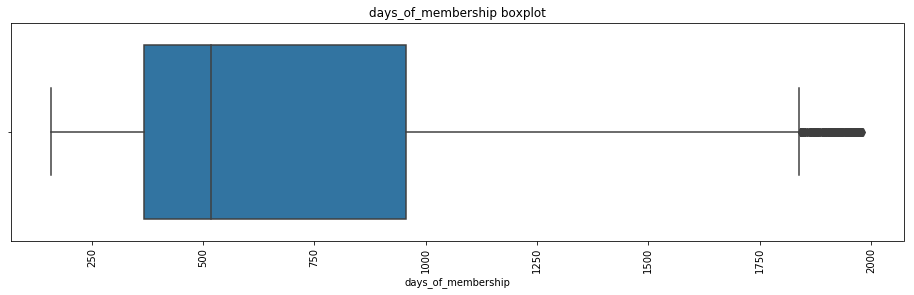

In [54]:
# Income boxplot
plt.figure(figsize=(16, 4))
sns.boxplot(df_profile['days_of_membership'])
plt.title('days_of_membership boxplot')
plt.xlabel('days_of_membership')
plt.xticks(rotation = 90)
plt.show();

In [55]:
df_profile['loyalty'] = pd.cut(df_profile['days_of_membership'], 
                                      bins=[0, 350, 700, 2000],labels=['trialist', 'dabbler', 'loyal'])

In [56]:
# label encode loyalty column
loyalty_label = df_profile['loyalty'].astype('category').cat.categories.tolist()
map_loyal = {'loyalty' : {k: v for k,v in zip(loyalty_label,list(range(1,len(loyalty_label)+1)))}}
print(map_loyal)
df_profile.replace(map_loyal, inplace=True)
df_profile.head(5)

{'loyalty': {'trialist': 1, 'dabbler': 2, 'loyal': 3}}


,cust_id,age,became_member_on,gender,income,age_bucket,income_bucket,year_of_membership,days_of_membership,loyalty
1,0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,1,112000,3,4,2017,535,2
3,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,1,100000,4,4,2017,602,2
5,e2127556f4f64592b11af22de27a7932,68,2018-04-26,2,70000,4,3,2018,250,1
8,389bc3fa690240e798340f5a15918d5c,65,2018-02-09,2,53000,4,2,2018,326,1
12,2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,2,51000,3,2,2017,416,2


In [57]:
# dropping original columns 
df_profile.drop(columns = ['age','income','became_member_on', 'days_of_membership'], axis=1, inplace=True)
df_profile.head(5)

,cust_id,gender,age_bucket,income_bucket,year_of_membership,loyalty
1,0610b486422d4921ae7d2bf64640c50b,1,3,4,2017,2
3,78afa995795e4d85b5d9ceeca43f5fef,1,4,4,2017,2
5,e2127556f4f64592b11af22de27a7932,2,4,3,2018,1
8,389bc3fa690240e798340f5a15918d5c,2,4,2,2018,1
12,2eeac8d8feae4a8cad5a6af0499a211d,2,3,2,2017,2


## 3. Transcript Dataset
Processing to be applied

* Only keep events as ' offer completed' and 'offer viewed'
* Convert time in days
* rename person with cust_id and apply encoding used in profile data
* extract key-value pairs from 'value' column
	1. apply encoding for offer_id

In [58]:
# creating a copy
df_transcript = transcript.copy()
df_transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [59]:
df_transcript = df_transcript[(df_transcript['event'] == 'offer completed') | (df_transcript['event'] == 'offer viewed')]


In [60]:
# Convert time in days
df_transcript['time_days'] = df_transcript['time']/24

In [61]:
# rename person with cust_id and apply encoding used in profile data
df_transcript.rename(columns={'person':'cust_id'},inplace=True)

In [62]:
df_transcript.head(5)

,event,cust_id,time,value,time_days
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0.0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0.0
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0.0


In [63]:
# extract key-value pairs from 'value' column
keys = []
for idx, row in df_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
keys

['offer id', 'offer_id', 'reward']

In [64]:
#create columns and specify the datatype of each of them
df_transcript['offer_id'] = '' # datatype : string
df_transcript['reward'] = 0  # datatype : integer

In [65]:
# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in df_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            df_transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'reward':
            df_transcript.at[idx, 'reward'] = row['value'][k]

In [66]:
df_transcript.head(5)

,event,cust_id,time,value,time_days,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0.0,f19421c1d4aa40978ebb69ca19b0e20d,0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0.0,5a8bc65990b245e5a138643cd4eb9837,0
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,ae264e3637204a6fb9bb56bc8210ddfd,0
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0.0,5a8bc65990b245e5a138643cd4eb9837,0


In [67]:
df_transcript.drop(['value','time'], axis=1, inplace=True)

In [68]:
df_transcript.head(5)

,event,cust_id,time_days,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0.0,5a8bc65990b245e5a138643cd4eb9837,0
12652,offer viewed,102e9454054946fda62242d2e176fdce,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0.0,5a8bc65990b245e5a138643cd4eb9837,0


In [69]:
event_label = df_transcript['event'].astype('category').cat.categories.tolist()
event_map = {'event' : {k: v for k,v in zip(event_label,list(range(1,len(event_label)+1)))}}
print(event_map)
df_transcript.replace(event_map, inplace=True)

{'event': {'offer completed': 1, 'offer viewed': 2}}


In [70]:
df_transcript.replace(map_offer_id, inplace=True)

# C. Merging the 3 dataset - Portfolio, Profile, Transcript 


In [71]:
df_transcript.head(5)

,event,cust_id,time_days,offer_id,reward
12650,2,389bc3fa690240e798340f5a15918d5c,0.0,9,0
12651,2,d1ede868e29245ea91818a903fec04c6,0.0,6,0
12652,2,102e9454054946fda62242d2e176fdce,0.0,5,0
12653,2,02c083884c7d45b39cc68e1314fec56c,0.0,8,0
12655,2,be8a5d1981a2458d90b255ddc7e0d174,0.0,6,0


In [72]:
df_portfolio.head(5)

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,7,8,1,1.0,1,1,1,0
1,0.50,5,5,1,1.0,1,1,1,1
2,0.00,4,4,3,0.0,1,1,0,1
3,0.25,7,7,1,0.5,1,1,0,1
4,1.00,10,1,2,0.5,1,0,0,1


In [73]:
df_profile.head(5)

,cust_id,gender,age_bucket,income_bucket,year_of_membership,loyalty
1,0610b486422d4921ae7d2bf64640c50b,1,3,4,2017,2
3,78afa995795e4d85b5d9ceeca43f5fef,1,4,4,2017,2
5,e2127556f4f64592b11af22de27a7932,2,4,3,2018,1
8,389bc3fa690240e798340f5a15918d5c,2,4,2,2018,1
12,2eeac8d8feae4a8cad5a6af0499a211d,2,3,2,2017,2


In [74]:
# merge 'df_transcript' dataset with 'df_portfolio' on 'offer_id'
print(df_transcript.shape)
print(df_portfolio.shape)
df =df_transcript.merge(df_portfolio,how='left',on='offer_id')
print(df.shape)

(91304, 5)
(10, 9)
(91304, 13)


In [75]:
# merge 'df' dataset with 'df_profile' on 'cust_id'
print(df.shape)
print(df_profile.shape)
df =df.merge(df_profile,how='left',on='cust_id')
print(df.shape)

(91304, 13)
(14825, 6)
(91304, 18)


In [76]:
df.head(5)

,event,cust_id,time_days,offer_id,reward_x,difficulty,duration,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,gender,age_bucket,income_bucket,year_of_membership,loyalty
0,2,389bc3fa690240e798340f5a15918d5c,0.0,9,0,0.25,5,1,0.5,1,1,1,1,2.0,4.0,2.0,2018.0,1.0
1,2,d1ede868e29245ea91818a903fec04c6,0.0,6,0,0.00,3,3,0.0,1,1,1,0,3.0,3.0,2.0,2017.0,2.0
2,2,102e9454054946fda62242d2e176fdce,0.0,5,0,0.50,5,1,1.0,1,1,1,1,1.0,4.0,2.0,2016.0,3.0
3,2,02c083884c7d45b39cc68e1314fec56c,0.0,8,0,0.50,7,1,1.0,1,1,1,0,1.0,1.0,1.0,2016.0,3.0
4,2,be8a5d1981a2458d90b255ddc7e0d174,0.0,6,0,0.00,3,3,0.0,1,1,1,0,2.0,2.0,2.0,2014.0,3.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 18 columns):
event                 91304 non-null int64
cust_id               91304 non-null object
time_days             91304 non-null float64
offer_id              91304 non-null int64
reward_x              91304 non-null int64
difficulty            91304 non-null float64
duration              91304 non-null int64
offer_type            91304 non-null int64
reward_y              91304 non-null float64
channel_email         91304 non-null int64
channel_mobile        91304 non-null int64
channel_social        91304 non-null int64
channel_web           91304 non-null int64
gender                82304 non-null float64
age_bucket            82304 non-null float64
income_bucket         82304 non-null float64
year_of_membership    82304 non-null float64
loyalty               82304 non-null float64
dtypes: float64(8), int64(9), object(1)
memory usage: 13.2+ MB


In [78]:
# Check for duplicates
df.columns.duplicated().sum()

0

In [79]:
# Missing value check
df.isna().sum()

event                    0
cust_id                  0
time_days                0
offer_id                 0
reward_x                 0
difficulty               0
duration                 0
offer_type               0
reward_y                 0
channel_email            0
channel_mobile           0
channel_social           0
channel_web              0
gender                9000
age_bucket            9000
income_bucket         9000
year_of_membership    9000
loyalty               9000
dtype: int64

In [80]:
df.head()

,event,cust_id,time_days,offer_id,reward_x,difficulty,duration,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,gender,age_bucket,income_bucket,year_of_membership,loyalty
0,2,389bc3fa690240e798340f5a15918d5c,0.0,9,0,0.25,5,1,0.5,1,1,1,1,2.0,4.0,2.0,2018.0,1.0
1,2,d1ede868e29245ea91818a903fec04c6,0.0,6,0,0.00,3,3,0.0,1,1,1,0,3.0,3.0,2.0,2017.0,2.0
2,2,102e9454054946fda62242d2e176fdce,0.0,5,0,0.50,5,1,1.0,1,1,1,1,1.0,4.0,2.0,2016.0,3.0
3,2,02c083884c7d45b39cc68e1314fec56c,0.0,8,0,0.50,7,1,1.0,1,1,1,0,1.0,1.0,1.0,2016.0,3.0
4,2,be8a5d1981a2458d90b255ddc7e0d174,0.0,6,0,0.00,3,3,0.0,1,1,1,0,2.0,2.0,2.0,2014.0,3.0


In [81]:
# removing 9000 rows that contain NaNs
print(df.shape)
df = df.dropna(how='any',axis=0)
print(df.shape)

(91304, 18)
(82304, 18)


# D. Data Analysis on Master dataset to answer below questions 

*	1. Class imbalance based on event feature - offer completed vs offer viewed
*	2. Are there any offer type that is most commonly viewed but not completed
*	3. Which age bucket completes offer after viewed  
*	4. Which gender has higher complete proportion of offer viewed 
*	5. Which income group completes most offer after viewing on offer viewed vs offer completed 
*	6. Impact of membership year on offer viewed vs offer completed


In [82]:
# applying mapping to the values to get category
df['event_map'] = df['event'].map({1: 'Completed', 2: 'Viewed'})
df['offer_type_map'] = df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
df['income_bucket_map'] = df['income_bucket'].map({1: 'low', 2: 'Med', 3:'High', 4:'VeryHigh'})
df['age_group_map'] = df['age_bucket'].map({1: 'college', 2: 'adult', 3:'mature', 4:'elderly'})
df['gender_map'] = df['gender'].map({1: 'F', 2: 'M', 3:'O'})

In [83]:
df.head(5)

,event,cust_id,time_days,offer_id,reward_x,difficulty,duration,offer_type,reward_y,channel_email,...,gender,age_bucket,income_bucket,year_of_membership,loyalty,event_map,offer_type_map,income_bucket_map,age_group_map,gender_map
0,2,389bc3fa690240e798340f5a15918d5c,0.0,9,0,0.25,5,1,0.5,1,...,2.0,4.0,2.0,2018.0,1.0,Viewed,BOGO,Med,elderly,M
1,2,d1ede868e29245ea91818a903fec04c6,0.0,6,0,0.00,3,3,0.0,1,...,3.0,3.0,2.0,2017.0,2.0,Viewed,Informational,Med,mature,O
2,2,102e9454054946fda62242d2e176fdce,0.0,5,0,0.50,5,1,1.0,1,...,1.0,4.0,2.0,2016.0,3.0,Viewed,BOGO,Med,elderly,F
3,2,02c083884c7d45b39cc68e1314fec56c,0.0,8,0,0.50,7,1,1.0,1,...,1.0,1.0,1.0,2016.0,3.0,Viewed,BOGO,low,college,F
4,2,be8a5d1981a2458d90b255ddc7e0d174,0.0,6,0,0.00,3,3,0.0,1,...,2.0,2.0,2.0,2014.0,3.0,Viewed,Informational,Med,adult,M


In [84]:
df.columns

Index(['event', 'cust_id', 'time_days', 'offer_id', 'reward_x', 'difficulty',
       'duration', 'offer_type', 'reward_y', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'gender', 'age_bucket',
       'income_bucket', 'year_of_membership', 'loyalty', 'event_map',
       'offer_type_map', 'income_bucket_map', 'age_group_map', 'gender_map'],
      dtype='object')

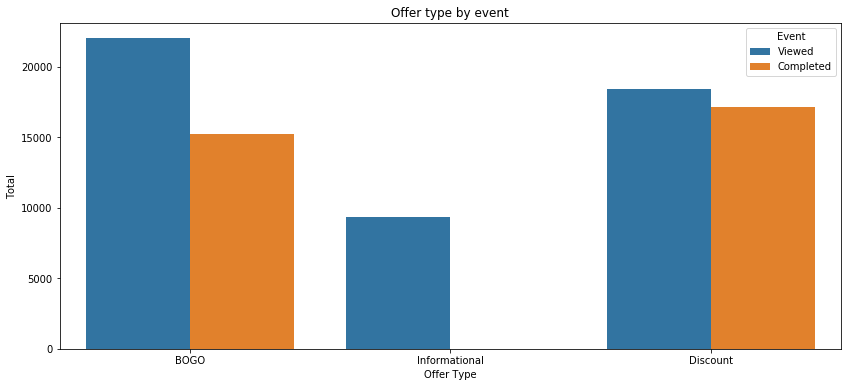

In [85]:
plt.figure(figsize=(14, 6))
sns.countplot(x="offer_type_map", hue="event_map", data=df)
plt.title('Offer type by event')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

Offer type = 'Discount' has higher proportion of offers completed compared with 'BOGO'

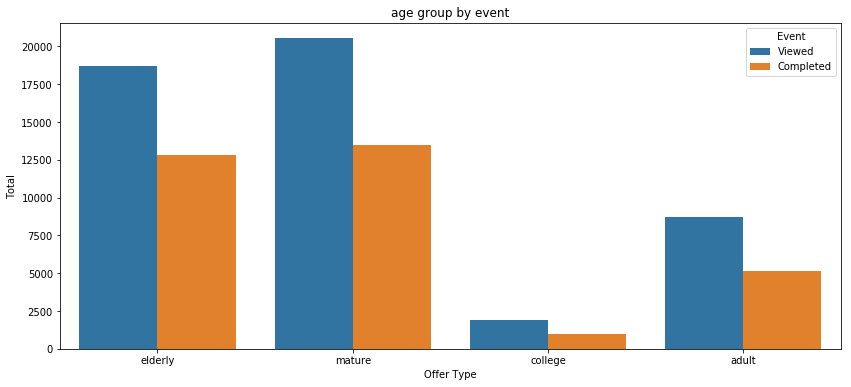

In [86]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group_map", hue="event_map", data=df)
plt.title('age group by event')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

Elderly (Age : 60+) and Mature (Age : 40-60) have higher number of offers viewed and completed

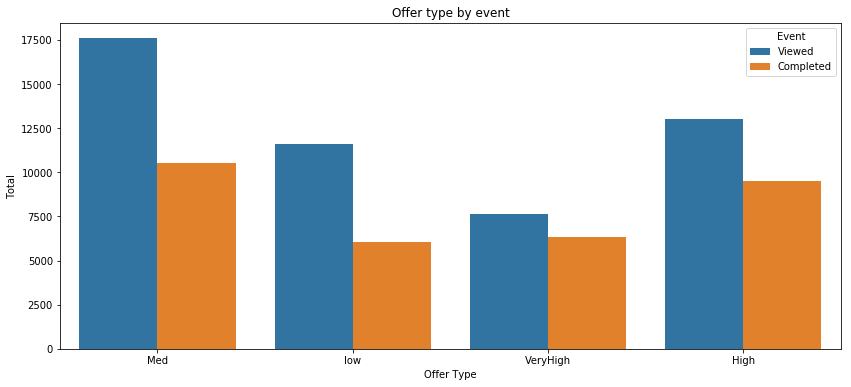

In [87]:
plt.figure(figsize=(14, 6))
sns.countplot(x="income_bucket_map", hue="event_map", data=df)
plt.title('Offer type by event')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

People with High and Very High Income have higher offer completion rate

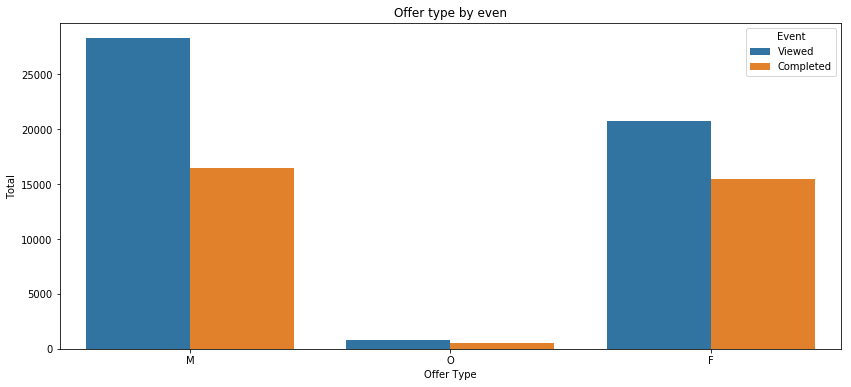

In [88]:
plt.figure(figsize=(14, 6))
sns.countplot(x="gender_map", hue="event_map", data=df)
plt.title('Offer type by even')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

Female gender has higher offer completion rate compared to Males

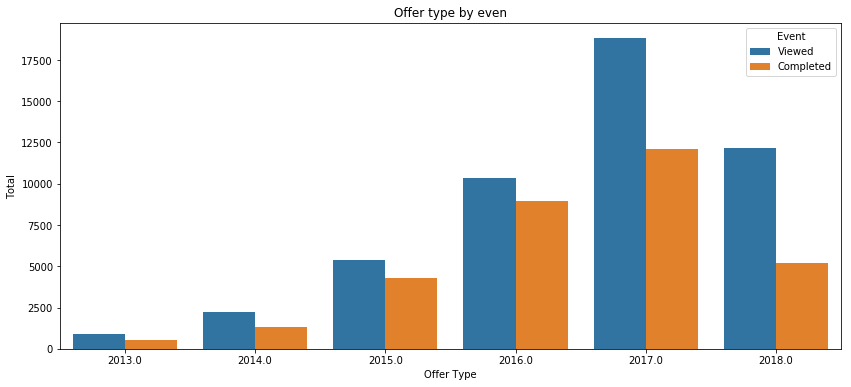

In [89]:
plt.figure(figsize=(14, 6))
sns.countplot(x="year_of_membership", hue="event_map", data=df)
plt.title('Offer type by even')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

2017 has most numbers of customers taking membership. However, customers taking membership in 2017 and 2018 have lower offer completion rate compared to customers taking membership in prior years

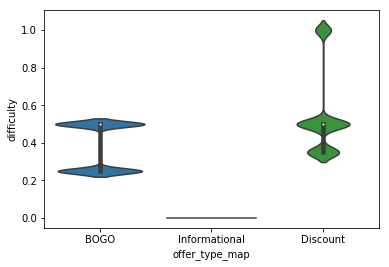

In [90]:
sns.violinplot(x="offer_type_map", y="difficulty", data=df, size=6)

# Data Modeling

We will build a model that will help classify whether a customer will complete the offer or just view

In [91]:
df.columns

Index(['event', 'cust_id', 'time_days', 'offer_id', 'reward_x', 'difficulty',
       'duration', 'offer_type', 'reward_y', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'gender', 'age_bucket',
       'income_bucket', 'year_of_membership', 'loyalty', 'event_map',
       'offer_type_map', 'income_bucket_map', 'age_group_map', 'gender_map'],
      dtype='object')

All features may not be important and some features (for e.g. 'reward') can act as leakage. Hence, selecting only those features that are important for predicting the two class

Those features are as follows:

*	time_days
*	offer_id
*	duration
*	difficulty
*	offer_type
*	gender
*	age_bucket
*	income_bucket
*	year_of_membership

Our target is: 'event' that will be either:
*	1 : offer completed
*	2 : offer viewed

In [92]:
df['event'].value_counts()

2    49860
1    32444
Name: event, dtype: int64

In [93]:
df['event'].value_counts(normalize = True)

2    0.605803
1    0.394197
Name: event, dtype: float64

In [94]:
#Split the data in dependent and independent variable 
X = df[[
    'time_days',
    'offer_id',
    'duration',
    'difficulty',
    'offer_type',
    'gender',
    'age_bucket',
    'income_bucket',
    'year_of_membership']]
Y = df['event']

In [95]:
# Split into test and train dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=2023)

In order to evaluate our models performance, we will use F1 score. F1 was chosen because :

This is a classification problem with slightly unbalanced dataset (60 : 40), to get a balance of precision and recall on the positive class it is better to look at f1 score than accuracy which looks at correctly classified observations both positive and negative

1. Decision Tree

In [96]:
from sklearn.metrics import f1_score
from sklearn import metrics

In [97]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)

print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))


Metrics on training data : 
             precision    recall  f1-score   support

          1       0.82      0.90      0.86     22692
          2       0.93      0.87      0.90     34920

avg / total       0.89      0.88      0.88     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.51      0.56      0.54      9752
          2       0.70      0.65      0.67     14940

avg / total       0.62      0.62      0.62     24692



2. Support Vector Machine

In [98]:
svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
train_pred = svm.predict(X_train)
test_pred = svm.predict(X_test)
print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))

Metrics on training data : 
             precision    recall  f1-score   support

          1       0.64      0.49      0.55     22692
          2       0.71      0.82      0.76     34920

avg / total       0.68      0.69      0.68     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.62      0.48      0.54      9752
          2       0.70      0.81      0.75     14940

avg / total       0.67      0.68      0.67     24692



3. Naive Bayes classifier

In [99]:
nb = GaussianNB() 
nb.fit(X_train, y_train) 
train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)
print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))

Metrics on training data : 
             precision    recall  f1-score   support

          1       0.51      0.55      0.53     22692
          2       0.69      0.65      0.67     34920

avg / total       0.62      0.61      0.61     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.51      0.56      0.53      9752
          2       0.69      0.65      0.67     14940

avg / total       0.62      0.61      0.62     24692



4. Random Forest

In [100]:
rf = RandomForestClassifier(random_state = 2023)

rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))

Metrics on training data : 
             precision    recall  f1-score   support

          1       0.84      0.81      0.83     22692
          2       0.88      0.90      0.89     34920

avg / total       0.87      0.87      0.87     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.52      0.52      0.52      9752
          2       0.69      0.69      0.69     14940

avg / total       0.62      0.62      0.62     24692



5. K-Nearest Neighbors

In [101]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)
print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))

Metrics on training data : 
             precision    recall  f1-score   support

          1       0.71      0.65      0.68     22692
          2       0.79      0.83      0.81     34920

avg / total       0.76      0.76      0.76     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.54      0.50      0.52      9752
          2       0.69      0.73      0.71     14940

avg / total       0.63      0.64      0.63     24692



6. LogisticRegression

In [102]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
print("Metrics on training data : ")
print(metrics.classification_report(y_train,train_pred))
print("Metrics on test data : ")
print(metrics.classification_report(y_test,test_pred))

Metrics on training data : 
             precision    recall  f1-score   support

          1       0.55      0.31      0.40     22692
          2       0.65      0.84      0.73     34920

avg / total       0.61      0.63      0.60     57612

Metrics on test data : 
             precision    recall  f1-score   support

          1       0.56      0.31      0.40      9752
          2       0.65      0.84      0.73     14940

avg / total       0.62      0.63      0.60     24692



## Of the below 6 models, SVM is a more generalized model with training F1 (0.68) and test F1 (0.67) score ~0.67.  However, the score can be improved further by parameter tuning.


# Model refinement
#We can try below to get the best parameters

from sklearn.model_selection import GridSearchCV
  
#defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
#fitting the model for grid search
grid.fit(X_train, y_train)

#print best parameter after tuning
print(grid.best_params_)
  
#print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
  
#print classification report
print(classification_report(y_test, grid_predictions))

# Conclusion

In this project, I tried to analyze and make model to predict whether a Starbucks customer will just view the offer or complete it. First I explored the 3 datasets that were provided by looking at things such as missing values, duplciates, datatype and range and joted the changes that needs to be done. Then I did the necessary preprocessing on the data by creating features and converting them into a format that can be merged. All the 3 datasets were then merged to get a master database. Then EDA was performed to check the impact of differnt features on dependent variable. The EDA showed that majority customers are above the age of 40 years. Customers with income more than $70K per year have better completion rate and should be targeted. Female customers also have better completion rate than males and should be targeted. Then I built a classification model with offer viewed vs offer completed as the dependent variable. Various classification techniques such as Decision Tree, SVM, Random forest, Naive Bayes Classifier, Logistic Regression and KNN were tried and the technique that gave a good F1 score and more generalized result (train and test f1 score similar) was chosen - SVM with 0.68 F1 score 

# Improvement


There is scope to improve in below few areas -
1. Data processing : 10% Records with NaNs were removed. We can try various imputation methods (mean, median, mode) to impute the null values
2. Feature engineering : Outlier capping can be performed to remove extreme values and addition features could be created
3. Model refinement : Hyper parameter could have been optimized to further increase the model score


In [103]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Starbucks_Capstone_notebook.ipynb to html',
 '[NbConvertApp] Writing 557243 bytes to Starbucks_Capstone_notebook.html',
 '[NbConvertApp] Converting notebook Starbucks_Capstone_notebook-zh.ipynb to html',
 '[NbConvertApp] Writing 279110 bytes to Starbucks_Capstone_notebook-zh.html',
 '[NbConvertApp] Converting notebook v5.ipynb to html',
 '[NbConvertApp] Writing 613741 bytes to v5.html']